In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt# backprop
%matplotlib inline

In [29]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [30]:
f(3.0)

20.0

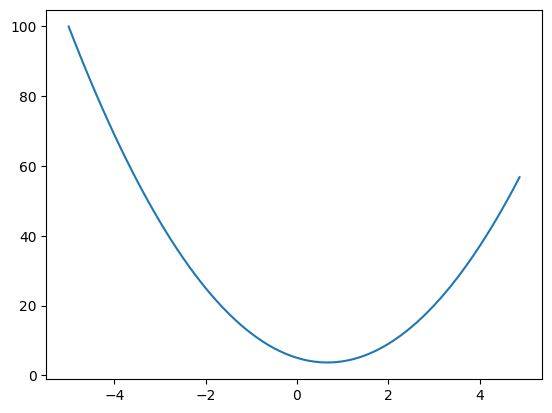

In [31]:
xs = np.arange(-5, 5, 0.125)
ys = f(xs)
plt.plot(xs, ys)

In [32]:
h = 0.000000000000001
x = 2 / 3
(f(x + h) - f(x)) / h

0.0

In [33]:
h = 0.0001

a = 2.0
b = -3.0
c = 10

d1 = a * b + c
a += h
d2 = a * b + c

print("d1:", d1)
print("d2:", d2)
print("slope:", (d2 - d1) / h)

d1: 4.0
d2: 3.999699999999999
slope: -3.000000000010772


In [34]:
class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        self.grad *= 1
        other.grad *= 1
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        self.grad *= other.data
        other.grad *= self.data
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        return Value(t, (self,), _op="tanh")


# x = Value(1, label="x")
# y = x.tanh()
# x, y

In [35]:
x = Value(3, label="x")
y = Value(-5, label="y")

a = x * y
b = Value(8, label="b")
c = a + b
c.label = "c"
d = Value(8, label="d")

L = c * d
L.label = "L"
# L.grad = 1

# a.label, b.label, c.label, d.label, res.label
# d._prev, d._op

In [36]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format="svg", rankdir="LR"):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    nodes, edges = trace(root)
    dot = Digraph(
        format=format, graph_attr={"rankdir": rankdir}
    )  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(
            name=str(id(n)),
            label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

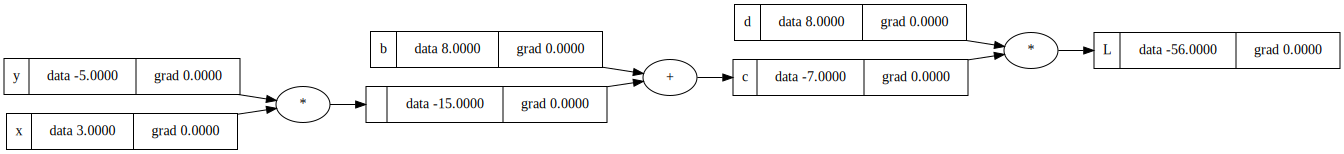

In [37]:
draw_dot(L)

In [38]:
# incoming values
x1 = Value(2, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3, label="w1")
w2 = Value(1, label="w2")

# bias
b = Value(6.8813735870195432, label="b")

# calc
x1w1 = x1 * w1
x1w1.label = "x1w1"

x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.label = "x1w1 + x2w2"

o = x1w1_x2w2 + b
o.label = "o"

# activation function
t = o.tanh()
t.label = "t"

In [39]:
# backprop

t.grad = 1

o.grad = t.grad * (1 - t.data**2)


# addition
b.grad = o.grad
x1w1_x2w2.grad = o.grad

x1w1.grad = x1w1_x2w2.grad
x2w2.grad = x1w1_x2w2.grad

# multiplication
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data

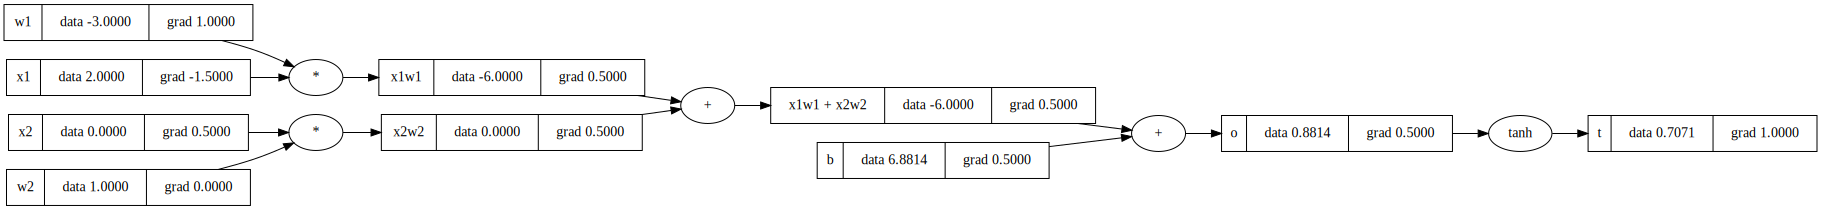

In [40]:
draw_dot(t)

# Auto Grad

In [41]:
class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad = out.grad
            other.grad = out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)

        out = Value(t, (self,), _op="tanh")

        def _backward():
            self.grad = out.grad * (1 - out.data**2)

        out._backward = _backward
        return out

In [42]:
# incoming values
x1 = Value(2, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3, label="w1")
w2 = Value(1, label="w2")

# bias
b = Value(6.8813735870195432, label="b")

# calc
x1w1 = x1 * w1
x1w1.label = "x1w1"

x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.label = "x1w1 + x2w2"

o = x1w1_x2w2 + b
o.label = "o"

# activation function
t = o.tanh()
t.label = "t"

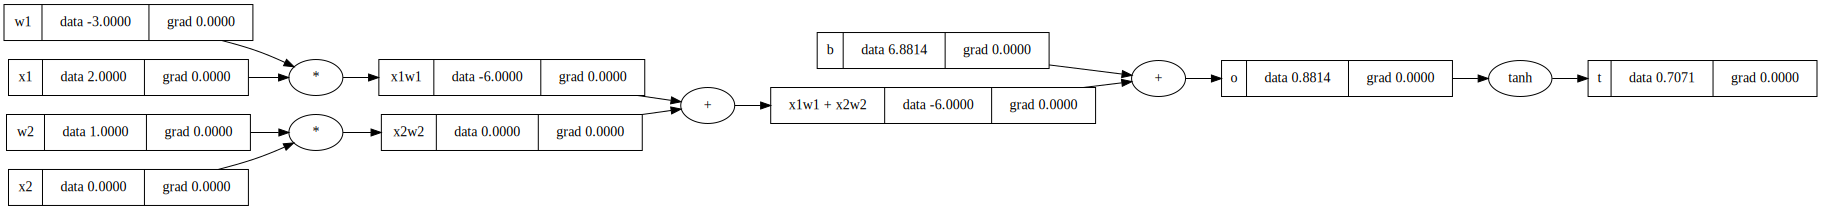

In [43]:
draw_dot(t)

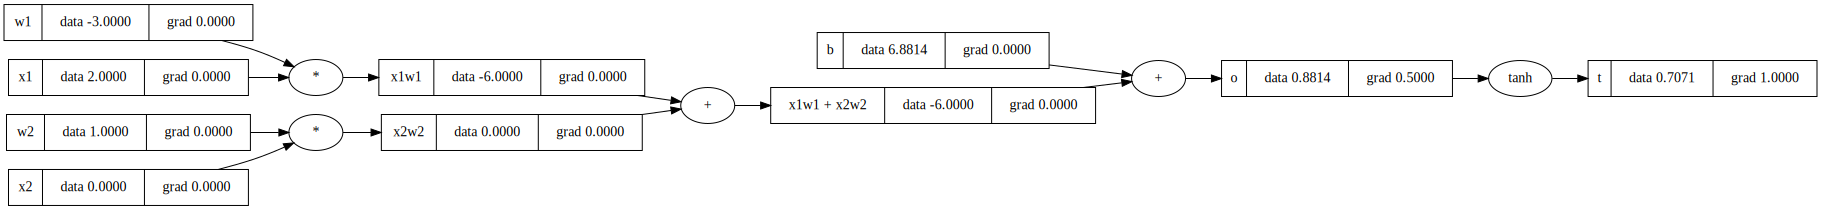

In [44]:
t.grad = 1
t._backward()
draw_dot(t)
# o._backward()
# draw_dot(t)
# x1w1_x2w2._backward()
# draw_dot(t)
# x1w1._backward()
# draw_dot(t)
# x2w2._backward()
# draw_dot(t)

Instead of the above thing, do topological sort and iterate through each node